## Only using tensorflow to import a dataset

In [781]:
import numpy as np
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

<ipython-input-677-de66bb0fd666>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


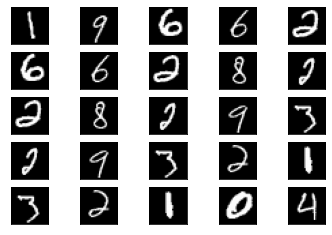

In [677]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

## Code

## Import

In [678]:
import numpy as np

## flatten and reshape

In [679]:
print("x_train:", x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1).T # flatten
print("x_train flatten:", x_train.shape)

print("x_test:", x_test.shape)
x_test = x_test.reshape(x_test.shape[0], -1).T # flatten
print("x_test flatten:", x_test.shape)

print("y_train:", y_train.shape)
y_train = y_train.reshape(y_train.shape[0],1).T # reshape
print("y_train:", y_train.shape)

print("y_test:", y_test.shape)
y_test = y_test.reshape(y_test.shape[0],1).T # reshape
print("y_test:", y_test.shape)

x_train: (60000, 28, 28)
x_train flatten: (784, 60000)
x_test: (10000, 28, 28)
x_test flatten: (784, 10000)
y_train: (60000,)
y_train: (1, 60000)
y_test: (10000,)
y_test: (1, 10000)


## One Hot

In [779]:
y_train_onehot = np.zeros((len(np.unique(y_train)), y_train.shape[1]), dtype=np.float32)
y_test_onehot = np.zeros((len(np.unique(y_test)), y_test.shape[1]), dtype=np.float32)

print(y_train_onehot)
print(y_train_onehot.shape)
print(y_train.ravel())

y_train_onehot[y_train, y_train] = 1
y_test_onehot[y_test, y_test] = 1

print(y_train_onehot) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10, 60000)
[5 0 4 ... 5 6 8]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Normalization

In [681]:
x_train = x_train/255
x_test = x_test/255

## initialize_parameters

In [682]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1], dtype=np.float32) * np.sqrt(2./layers_dims[l-1])
        parameters['b'+str(l)] = np.ones((layers_dims[l], 1), dtype=np.float32)
    
    return parameters

## activation_funtion

In [683]:
def activation_funtion(Z, activation):
    if activation == "relu":
        return np.maximum(np.zeros(1), Z)
        
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-Z))
    
    return Z

## forward_propagation

In [684]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters) // 2
    cache['A0'] = X
    
    for l in range(1,L):
        cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
        cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])

    l += 1
    
    cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
    cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    
    return cache

## compute_cost

In [685]:
def compute_cost(AL,Y, loss = "cross_entropy"):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        epsilon = 1e-7
        cost = -(1/m) * np.sum(np.multiply(np.log(AL + epsilon), Y) + np.multiply(np.log(1-AL + epsilon), 1-Y))
        return np.squeeze(cost)


In [686]:
def activation_derivative(Z, activation):
    if activation == "relu":
        dZ = np.ones(Z.shape)
        return (dZ >= 0).astype(int)
        
    if activation == "sigmoid":
        return np.multiply(activation_funtion(Z, "sigmoid"), (1- activation_funtion(Z, "sigmoid")))
    
    return Z

## back_propagation

In [687]:
def back_propagation(X, Y, parameters, cache, activation):
    grads = {}
    L = len(parameters) // 2
    m = Y.shape[1]
    
    grads["dZ" + str(L)] = cache['A' + str(L)] - Y
    grads["dW" + str(L)] = (1/m) * np.dot(grads["dZ" + str(L)], cache['A' + str(L-1)].T)
    grads["db" + str(L)] = (1/m) * np.sum(grads["dZ" + str(L)], axis= 1, keepdims= True)
    
    for l in range(L-1,1,-1):
        grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))        
        grads["dW" + str(l)] = (1/m) * np.dot(grads["dZ" + str(l)], cache['A' + str(l-1)].T)
        grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    l -= 1
    
    grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))
    grads["dW" + str(l)] = (1/m) * np.dot(grads["dZ" + str(l)], cache['A' + str(l-1)].T)
    grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    
    return grads

## update_parameters

In [688]:
def update_parameters(grads, paramaters, lr=0.01):
    
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - np.multiply(grads['dW'+str(l)], lr)
        parameters['b'+str(l)] = parameters['b'+str(l)] - np.multiply(grads['db'+str(l)], lr)
    
    return parameters

## prediction

In [689]:
def prediction(X, Y, parameters, activation):
    cache = forward_propagation(X, parameters, activation)
    
    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y)
    
    pred = cache['A' + str(len(parameters) // 2)] - Y
    
    print(pred)
    
    return "train cost: " + str(cost)

In [738]:
layers_dims = [x_train.shape[0],64,64,10]
activation = ["relu","relu","sigmoid"]
# loss_funtion = "cross_entropy"

print(x_train.shape)
print(y_train.shape)

parameters = initialize_parameters(layers_dims)

iter = 100

for i in range(iter):
    cache = forward_propagation(x_train, parameters, activation)

    
    if i % 10 == 0:
        cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, y_train_onehot)
        print("cost train: " + str(cost), end= " ")
        cache_test = forward_propagation(x_test, parameters, activation)
        cost = compute_cost(cache_test['A' + str(len(parameters) // 2)].T, y_test_onehot)
        print("cost test: " + str(cost))
        
    grads = back_propagation(x_train, y_train_onehot, parameters, cache, activation)

    parameters = update_parameters(grads, parameters, 0.001)

print(parameters)


(784, 60000)
(1, 60000)
cost train: 20.870153674417267 cost test: 20.82535112855044
cost train: 8.178050195609329 cost test: 8.107171968021479
cost train: 3.273705282413295 cost test: 3.222058948952886
cost train: 1.7242741324909145 cost test: 1.6908565324151816
cost train: 1.1001122019982708 cost test: 1.0763875323158258
cost train: 0.7839076302948397 cost test: 0.7659992100288759
cost train: 0.5986815348846601 cost test: 0.5846097420675432
cost train: 0.47915088278764145 cost test: 0.4677866904265905
cost train: 0.3965595214086097 cost test: 0.3872071632958855
cost train: 0.3365382992326146 cost test: 0.32874201539419934
{'W1': array([[-0.00515452, -0.03721859,  0.0375219 , ...,  0.05331442,
        -0.03996837, -0.0971257 ],
       [-0.02765206, -0.03304623,  0.0439572 , ..., -0.07284549,
        -0.05505025, -0.02788974],
       [ 0.09556141,  0.05338129, -0.01268777, ..., -0.04724477,
         0.00419923,  0.02503784],
       ...,
       [ 0.00878718, -0.08416378, -0.00717996, ...

In [745]:
for i in y_train:
    print(i)

for i in y_train_onehot:
    print(i)
    
for i in cache['A' + str(len(parameters) // 2)]:
    print(i)

[5 0 4 ... 5 6 8]
[1. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.01301706 0.02194843 0.0620483  ... 0.04324547 0.04653634 0.09080087]
[0.01606585 0.02329078 0.03401779 ... 0.01079658 0.01075386 0.01643013]
[0.02907044 0.03589141 0.05251756 ... 0.04544487 0.09356967 0.1374673 ]
[0.00861062 0.00579134 0.1185011  ... 0.0047468  0.01596865 0.02641748]
[0.02757167 0.00984335 0.05430216 ... 0.10088289 0.05551691 0.02221777]
[0.01409305 0.01007792 0.01867886 ... 0.01342356 0.0151096  0.01251653]
[0.03948782 0.01907394 0.05291029 ... 0.01588136 0.04556536 0.01479304]
[0.03032468 0.01581482 0.10413698 ... 0.03960177 0.02367156 0.03706323]
[0.03374546 0.08802815 0.13426971 ... 0.03081023 0.04625212 0.02871511]
[0.02967376 0.05547924 0.02611933 ... 0.01091196 0.02695101 0.02394039]


In [728]:
layers_dims = [32,18,7,2] # 3NN
activation = ["relu","relu","sigmoid"] # 3 Activation to 3NN
# loss_funtion = "cross_entropy"

X = np.random.randn(layers_dims[0],15) * 10
Y = np.array([[0, 1, 0.2, 0.5, 0.2, 0, 1, 0.2, 0.5, 0.2, 0, 1, 0.2, 0.5, 0.2]])

parameters = initialize_parameters(layers_dims)

iter = 1500

for i in range(iter):
    cache = forward_propagation(X, parameters, activation)

    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y)
    if i % 10 == 0:
        print(cost)
    grads = back_propagation(X, Y, parameters, cache, activation)

    parameters = update_parameters(grads, parameters, 0.02)

print(parameters)


7.087551667752337
0.7670714343871939
0.7145558898326894
0.7053399976700095
0.749072369725041
0.7249678977630684
0.7125996532111294
0.7056153932557334
0.7010020803471931
0.6984628564346628
0.6968732547099894
0.6955486603481176
0.694365849426454
0.6933115723571175
0.6923806910777184
0.6915596142126554
0.6908298746701544
0.6901760945843625
0.6895722225666671
0.6890064235150484
0.6884744520571767
0.6878365983327555
0.6870418012295926
0.6865005411423755
0.6863027908010135
0.6866205262932178
0.6868226874667515
0.6866318476829996
0.6861400516116382
0.6855191968170837
0.6846888346458506
0.6838326093710568
0.6831122764573918
0.682571567165309
0.6822019036468782
0.6819791949029664
0.6818767777239496
0.6818660736810912
0.6819209631805433
0.6821010142655547
0.6823760884816212
0.6826642088171176
0.6828745553078606
0.6829398991886189
0.6828456590335888
0.6826283237380656
0.6823478181008222
0.6820593577827948
0.6818001170121627
0.6815888710554499
0.6814300577235871
0.6813224176367819
0.68125694698105